<a href="https://colab.research.google.com/github/suren777/Ml-AI-in-finance/blob/master/heston_vol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install QuantLib-Python
import QuantLib as ql
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

     |████████████████████████████████| 17.4MB 4.2MB/s 


In [0]:
raw_expiries = """03 September 2019	04 September 2019	06 September 2019	09 September 2019	11 September 2019	13 September 2019	16 September 2019	18 September 2019	20 September 2019	27 September 2019	30 September 2019	04 October 2019	11 October 2019	18 October 2019	31 October 2019	15 November 2019	29 November 2019	20 December 2019	31 December 2019	17 January 2020	31 January 2020	20 March 2020	31 March 2020	19 June 2020	30 June 2020	18 September 2020	18 December 2020	18 June 2021	17 December 2021	31 December 2021	30 December 2022	29 December 2023	31 December 2024	31 December 2025"""
raw_val_date = """13 August 2019"""
raw_forwards = """2920.48	2920.22	2920.16	2920.39	2920.73	2920.81	2921.07	2920.91	2921.11	2921.06	2920.94	2920.95	2921.1	2920.42	2920.72	2920.88	2921.2	2921.69	2921.68	2921.93	2921.93	2922.47	2924	2922.27	2922.2	2922.49	2923.09	2924.34	2925.62	2923.76	2924.13	2923.12	2923.08	2921.56	2918.88	2912.34	2906.36	2906.39	2893.16	2880.63	2869.96	2861.53"""
spot = 2920.9
moneyness =list( a/100. for a in range(80,125,5))
strikes = list(spot*m for m in moneyness)
val_date = datetime.strptime(raw_val_date, '%d %B %Y')
calculation_date = ql.Date(val_date.day, val_date.month, val_date.year)

In [0]:
expiries = [datetime.strptime(expiry, '%d %B %Y') for expiry in raw_expiries.split("\t")]
forwards = [float(forward) for forward in raw_forwards.split('\t')]
ql_spot = ql.QuoteHandle(ql.SimpleQuote(spot))
ql_expiries = [ql.Date(expiry.day, expiry.month, expiry.year) for expiry in expiries]

ql.Settings.instance().evaluationDate = calculation_date
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

In [0]:
yield_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 0.2/100, day_count))
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 0.0, day_count))  

In [0]:
def setup_model(yield_ts, dividend_ts, spot, theta, kappa, eta, rho, v0):
    process = ql.HestonProcess(yield_ts, dividend_ts, spot, v0, kappa, theta, eta, rho)
    bs_process = ql.BlackScholesProcess(spot, yield_ts, ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, 1, day_count)))
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model) 
    return model, engine, bs_process

def callOption(strike, expiry, engine):
    ql_option_type = ql.Option.Call 
    payoff = ql.PlainVanillaPayoff(ql_option_type, strike)
    exercise = ql.EuropeanExercise(expiry)
    opt = ql.VanillaOption(payoff, exercise)
    opt.setPricingEngine(engine)
    return opt

def impliedVol(strike, expiry, engine, bs_process, target_vol=0.1):
    opt = callOption(strike, expiry, engine)
    return opt.impliedVolatility(target_vol, bs_process)

def impliedVolGrid(strikes, expiries, engine, bs_process, target_vol=0.1):
    vol_grid=np.full(shape=(len(expiries), len(strikes)), fill_value=np.nan)
    for e, expiry in enumerate(expiries):
        for s, strike in enumerate(strikes):
            try:
                vol_grid[e,s] = impliedVol(strike, expiry, engine, bs_process)
            except:
                pass
    return vol_grid


def optionGrid(strikes, expiries, engine, bs_process):
    return [[callOption(strike, expiry, engine) for strike in strikes] for expiry in expiries]

def optionPriceGrid(option_grid):
    opt_grid = [[opt.NPV() for opt in opts] for opts in option_grid]
    return np.array(opt_grid)

def optionVegaGrid(option_grid):
    opt_grid = [[opt.vega() for opt in opts] for opts in option_grid]
    return np.array(opt_grid)

In [0]:
theta = 0.042539; kappa = 3.178930; eta = 1.099581; rho = -0.793467; v0 = 0.031022

model, engine, bs_process = setup_model(yield_ts, dividend_ts, ql_spot, theta, kappa, eta, rho, v0)

In [0]:
option_grid = optionGrid(strikes, ql_expiries, engine, bs_process)
option_pr_grid = optionPriceGrid(option_grid)

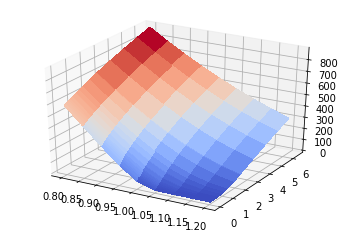

In [161]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
exp_yfcs = [day_count.yearFraction(calculation_date,date) for date in ql_expiries]
X, Y = np.meshgrid(moneyness,exp_yfcs)
_ = ax.plot_surface(X, Y, option_pr_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


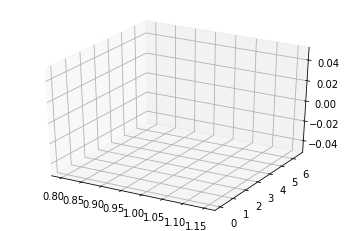

In [146]:
option_vega_grid = impliedVolGrid(strikes, expiries, engine, bs_process,target_vol=1)
fig = plt.figure()
ax = fig.gca(projection='3d')
_ = ax.plot_surface(X, Y, option_vega_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)

In [155]:
option_pr_grid

array([[ 5.84575179e+02,  4.39092690e+02,  2.95513380e+02,
         1.59088123e+02,  4.61567867e+01,  1.45123837e+00,
         1.22517600e-02,  7.18039647e-05, -1.59022360e-05],
       [ 5.84620336e+02,  4.39226181e+02,  2.95882550e+02,
         1.59875978e+02,  4.71096572e+01,  1.62117223e+00,
         1.62234285e-02,  1.28981253e-04, -8.90449420e-06],
       [ 5.84724965e+02,  4.39522008e+02,  2.96649646e+02,
         1.61423389e+02,  4.89366690e+01,  1.97840468e+00,
         2.66632116e-02,  3.23833325e-04,  3.91518230e-06],
       [ 5.84919198e+02,  4.40032188e+02,  2.97855605e+02,
         1.63670281e+02,  5.15080257e+01,  2.55159632e+00,
         4.94758249e-02,  9.34687296e-04,  2.65605948e-05],
       [ 5.85073916e+02,  4.40411807e+02,  2.98685694e+02,
         1.65118015e+02,  5.31270189e+01,  2.95477743e+00,
         7.00115160e-02,  1.66540711e-03,  5.19912057e-05],
       [ 5.85248532e+02,  4.40819118e+02,  2.99529738e+02,
         1.66526221e+02,  5.46810563e+01,  3.372387

In [106]:
test.impliedVolatility(1, bs_process)

RuntimeError: ignored